# Social network extracting from Shakespeare's plays

In [1]:
import pandas as pd
import social_network_for_plays as sn
import warnings
from IPython.core.display import display, HTML

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

## 0 Introduction

Do you have such experience that when reading a literary work, you always easily get lost in the numerous characters from the book and struggle with those complicated relationships among them. If that's the case, this project probably could help you. We focus on the 37 plays composed by William Shakespeare, offering an approach that render social networks that help you get a basic idea of what's going on. Along with the social networks, character importance, relationship importance and emotional stability of characters are presented as well.

## 1 Text Parsing

 * Compared to other types of literary work, play is much more better structrued. It always has five acts and 1-3 sciences for each act. For each play line it is always straightforward to identify who the line is spoken by. That being said, different plays always have something different. This fact requires a normalization before parsing. Once this step has been done, the play can be considered as a **Regular Language**. It means it can be parsed by a bunch of text or NLP tools including Regular Expression
 * For this project we did not borther to carry out text parsing. Because we find a data set that meet all requesments form kaggle: https://www.kaggle.com/kingburrito666/shakespeare-plays 

## 2 Data wrangling
### 2.1 Wrangling
 * Load data from csv file
 * Add new columns to be used later, including **Act**, **Scene** and **Code**
 * Check **social_network_for_plays.py** for other details

In [2]:
plays_df = sn.prepare_df_for_plays('data/plays.csv')
plays_df.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Code
Dataline,,,,,,,,
4,Henry Iv,1,1.1.1,King Henry Iv,"So shaken as we are, so wan with care,",1,1,Henry Iv||||1.1.001||||King Henry Iv
5,Henry Iv,1,1.1.2,King Henry Iv,"Find we a time for frighted peace to pant,",1,1,Henry Iv||||1.1.001||||King Henry Iv
6,Henry Iv,1,1.1.3,King Henry Iv,And breathe short-winded accents of new broils,1,1,Henry Iv||||1.1.001||||King Henry Iv
7,Henry Iv,1,1.1.4,King Henry Iv,To be commenced in strands afar remote.,1,1,Henry Iv||||1.1.001||||King Henry Iv
8,Henry Iv,1,1.1.5,King Henry Iv,No more the thirsty entrance of this soil,1,1,Henry Iv||||1.1.001||||King Henry Iv


### 2.2 Identify  conversation participants

Conversations are defined as:
 * The characters are in the same place at the same time;
 * The characters take turns speaking; and
 * The characters are mutually aware of each other and each character’s speech is mutually intended for the other to hear

With conversation defined as above, the following steps are carried out.

 * Aggregate the splited **PlayerLine** into complete section
 * Add **Target** if the previous and next are the same character
 * For a row, if **Target** is not **NaN** and not equal to **Player**, it means this line is spoken by **Player** to **Target**, we fill the **Relationship** column
 * Check **social_network_for_plays.py** for other details

In [3]:
m = sn.prepare_df_by_encoding(plays_df)
m.head(20)

,Code,PlayerLine,Play,Address,Act,Scene,Player,Relationship,Target
0,A Comedy Of Errors||||1.1.001||||Aegeon,"Proceed, Solinus, to procure my fall||||And by...",A Comedy Of Errors,1.1.001,1,1,Aegeon,NaN,NaN
1,A Comedy Of Errors||||1.1.002||||Duke Solinus,"Merchant of Syracuse, plead no more,||||I am n...",A Comedy Of Errors,1.1.002,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
2,A Comedy Of Errors||||1.1.003||||Aegeon,"Yet this my comfort: when your words are done,...",A Comedy Of Errors,1.1.003,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
3,A Comedy Of Errors||||1.1.004||||Duke Solinus,"Well, Syracusian, say in brief the cause||||Wh...",A Comedy Of Errors,1.1.004,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
4,A Comedy Of Errors||||1.1.005||||Aegeon,A heavier task could not have been imposed||||...,A Comedy Of Errors,1.1.005,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
5,A Comedy Of Errors||||1.1.006||||Duke Solinus,"Nay, forward, old man, do not break off so,|||...",A Comedy Of Errors,1.1.006,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
6,A Comedy Of Errors||||1.1.007||||Aegeon,"O, had the gods done so, I had not now||||Wort...",A Comedy Of Errors,1.1.007,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
7,A Comedy Of Errors||||1.1.008||||Duke Solinus,"And for the sake of them thou sorrowest for,||...",A Comedy Of Errors,1.1.008,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
8,A Comedy Of Errors||||1.1.009||||Aegeon,"My youngest boy, and yet my eldest care,||||At...",A Comedy Of Errors,1.1.009,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
9,A Comedy Of Errors||||1.1.010||||Duke Solinus,"Hapless AEgeon, whom the fates have mark'd||||...",A Comedy Of Errors,1.1.010,1,1,Duke Solinus,NaN,NaN


## 3 Relationship Matrix
 * Once **Target** has been identified, a relationship matrix can be extracted from the encoded data frame created by previous step
 * The values are the **conversation frequncies**
 * Check **social_network_for_plays.py** for other details

In [4]:
sn.extract_matrix(plays_df, 'Hamlet', m)

,Bernardo,Captain,Danes,First Ambassador,First Clown,First Player,First Priest,First Sailor,Francisco,Gentleman,Ghost,Guildenstern,Hamlet,Horatio,King Claudius,Laertes,Lord,Lord Polonius,Lucianus,Marcellus,Messenger,Ophelia,Osric,Player King,Player Queen,Prince Fortinbras,Queen Gertrude,Reynaldo,Rosencrantz,Second Clown,Servant,Voltimand
Bernardo,0,0,0,0,0,0,0,0,10,0,0,0,5,7,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
Captain,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Danes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Ambassador,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Clown,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0
First Player,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Priest,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
First Sailor,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Francisco,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
Gentleman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


## 4 Player emotional stability analysis
* With sentiment analysis from TextBlob we calculate the emotional stability for each player
* Formula is **emotional stability = standard deviation(sentiment.polarity) * standard deviation(sentiment.subjectivity)**

In [5]:
for p in ['Hamlet', 'Ophelia', 'King Claudius', 'Bernardo']:
    print(p, sn.personality(plays_df, 'Hamlet', p))

Hamlet 5.46
Ophelia 6.43
King Claudius 5.93
Bernardo 3.55


## 5 Social network visualization
  With everyhing ready, social networks can be visualized
 * Node size indicate the play importance
 * Node color indicate the play emotional stability, blue means stable, red unstable
 * Number of ★ indicate the relationship importance
 * Red ★ indicates a relationship between opposite gender
 * Blue ★ indicates a relationship between the same gender

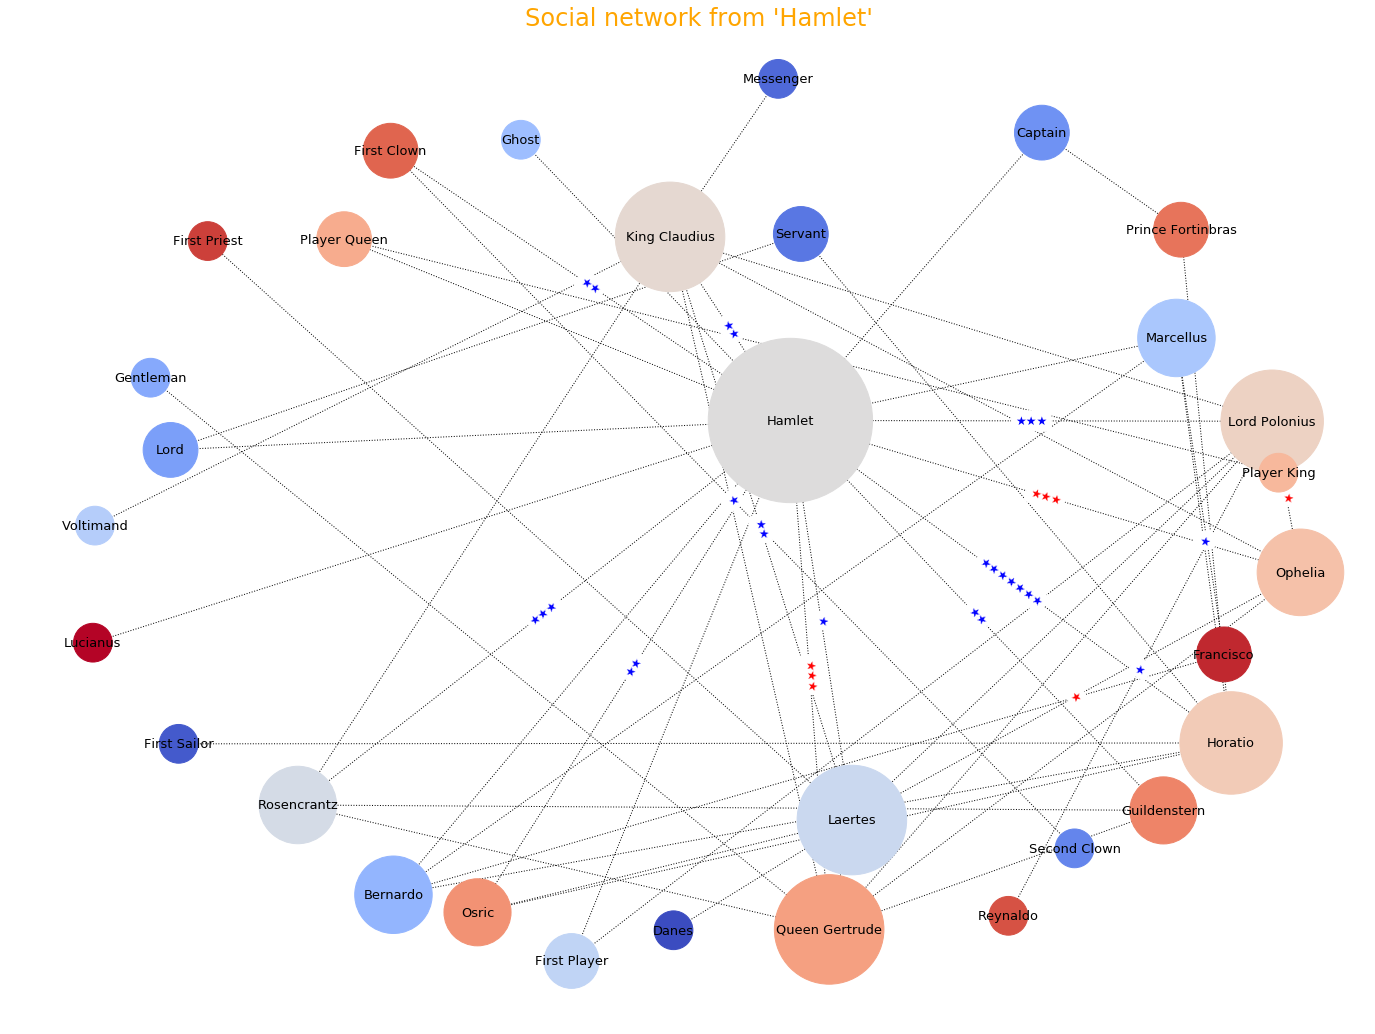

In [11]:
sn.plot_matrix(plays_df, 'Hamlet', m)

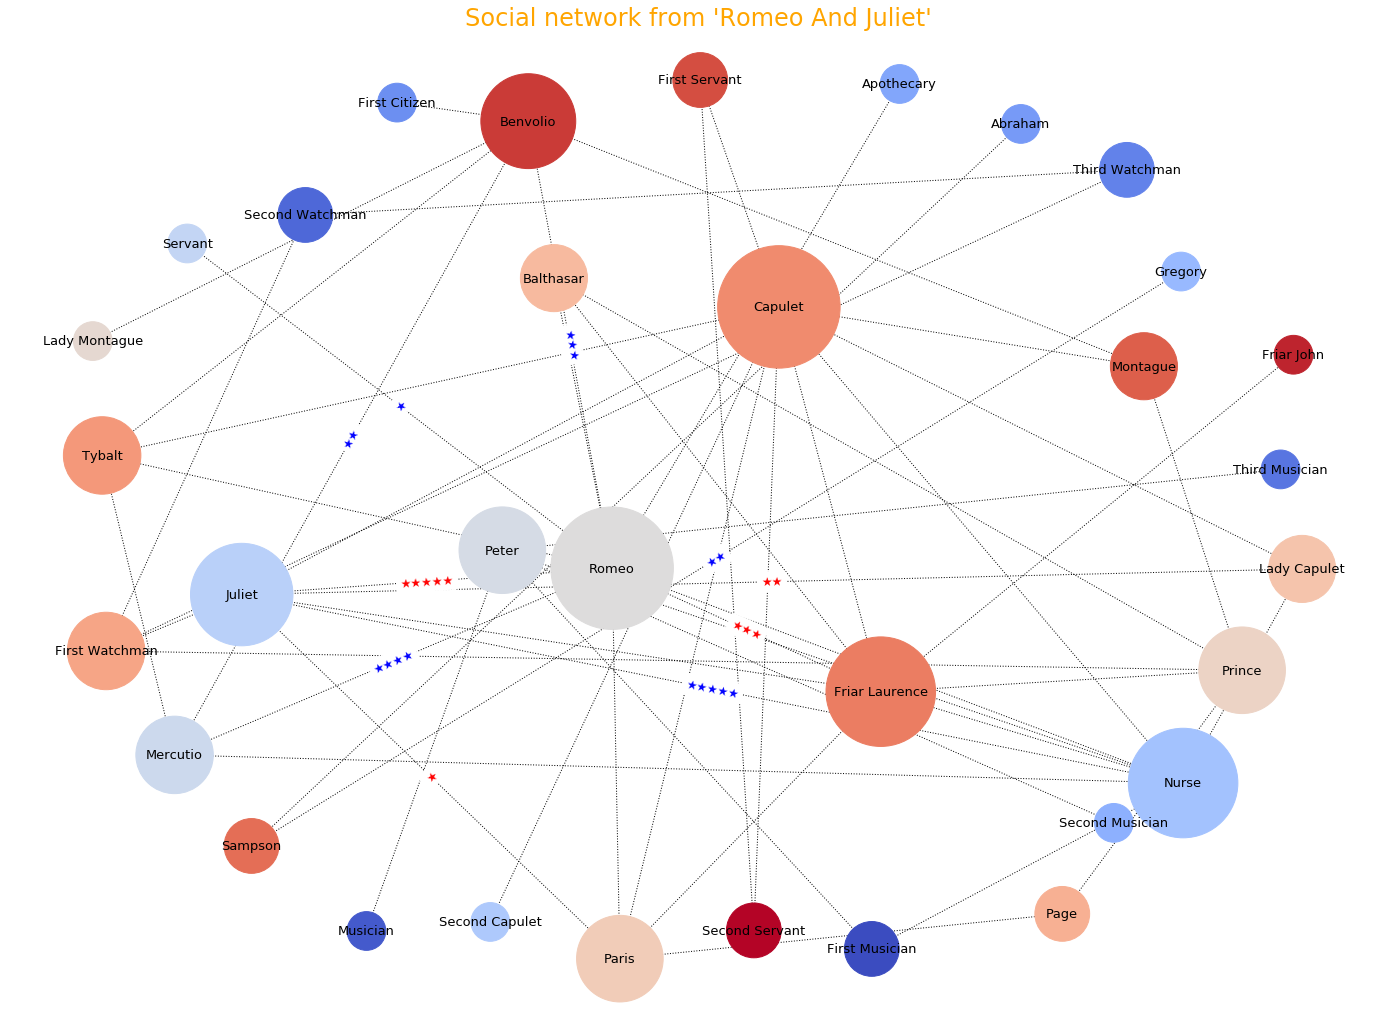

In [16]:
sn.plot_matrix(plays_df, 'Romeo And Juliet', m)